In [1]:
from Annotation_helper import *
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras

# Helper functions

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

# Loading data

In [2]:
matches = pd.read_csv("Matches/Bas2.csv", index_col=0)
transactions = load_transactions("../../Data/structured_data\VOC Cochin Slave Transactions 1706-1801 - IISH - Database - 2018 - v1.csv")
permissions = load_permissions("../../Data/structured_data\VOC Cochin Slave Transport Permissions 1770-1795 - IISH - Database - 2018 - v1.csv")

In [3]:
distances = pd.read_csv("Distances/distances_0.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
for i in range(1, 99):
    df2 = pd.read_csv(f"Distances/distances_{i}.csv", dtype={'permission_indx': 'uint16', 'transaction_indx': 'uint16', 'SlaafGender': 'bool', 'SlaafNaamNieuw': 'float16', 'BezitterGender': 'bool', 'BezitterVoornaam': 'float16', 'BezitterBeroep': 'float16', 'BezitterAchternaam': 'float16'})
    distances = pd.concat([distances, df2])

In [85]:
X = distances[distances['permission_indx'].isin(matches["permission_indx"].unique())]
X["Match"] = 0
for i, match in matches.iterrows():
    if match["transaction_indx"] != "None":
        indx = distances.query(f"permission_indx == {match['permission_indx']} & transaction_indx == {match['transaction_indx']}").index[0]
        X.iloc[indx, -1] = 1
data = X.to_numpy().astype("float")[:, 2:-1]
y = X.to_numpy().astype("float")[:, -1]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.5, random_state=42)

<ipython-input-85-699ce117a997>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Match"] = 0


# Normalizing data

In [90]:
X

,permission_indx,transaction_indx,SlaafGender,SlaafNaamNieuw,BezitterGender,BezitterVoornaam,BezitterBeroep,BezitterAchternaam,Match
50316,198,0,True,0.000000,True,0.083313,1.0,0.166626,0
50317,198,1,True,0.250000,True,0.083313,1.0,0.166626,0
50318,198,2,False,0.125000,True,0.083313,1.0,0.166626,0
50319,198,3,True,0.333252,True,0.083313,0.0,0.222168,0
50320,198,4,True,0.750000,True,0.416748,0.0,0.142822,0
...,...,...,...,...,...,...,...,...,...
201259,332,7192,False,0.125000,True,0.181763,0.0,0.285645,0
201260,332,7193,True,0.000000,True,0.181763,0.0,0.285645,0
201261,332,7194,True,0.125000,True,0.090881,0.0,0.000000,0
201262,332,7195,True,0.111084,True,0.090881,0.0,0.142822,0


# Oversampling

In [125]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

# Neural network

In [138]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X_train.shape[-1]),
    tf.keras.layers.Dense(1, activation='softmax')
])

In [139]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [140]:
history = model.fit(X_train, y_train, batch_size=2048, epochs=5)

Epoch 1/5
474/474 [==============================] - 3s 5ms/step - loss: 0.6182 - binary_accuracy: 0.5000
Epoch 2/5
474/474 [==============================] - 2s 5ms/step - loss: 0.5248 - binary_accuracy: 0.5000
Epoch 3/5
474/474 [==============================] - 2s 5ms/step - loss: 0.4780 - binary_accuracy: 0.5000
Epoch 4/5
474/474 [==============================] - 2s 5ms/step - loss: 0.4535 - binary_accuracy: 0.5000A: 1s - 
Epoch 5/5
474/474 [==============================] - 2s 5ms/step - loss: 0.4431 - binary_accuracy: 0.5000


In [132]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 6)                 42        
                                                                 
 dense_28 (Dense)            (None, 1)                 7         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


NameError: name 'colors' is not defined

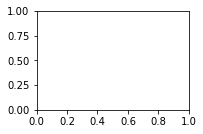

In [133]:
plot_metrics(history)

# Evaluating results

In [134]:
pred = model.predict(X_test)
pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

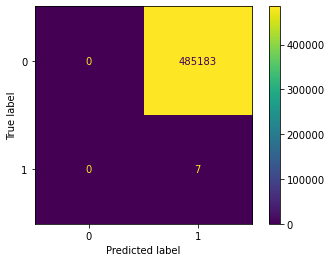

In [121]:
cm = confusion_matrix(y_test, np.round(pred.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()